In [1]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import re, string, random
import warnings

from collections import Counter
from spacy.matcher import Matcher 
from numpy import nan
from nltk.sentiment import SentimentIntensityAnalyzer
from statistics import mean
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk import FreqDist, classify, NaiveBayesClassifier
from pprint import pprint

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


nlp = spacy.load("en_core_web_sm")

nltk.download([
     "names",
     'wordnet',
     "stopwords",
     "state_union",
     "twitter_samples",
     "movie_reviews",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",
     'omw-1.4',
     'universal_tagset', ])

warnings.filterwarnings('ignore',category=DeprecationWarning)
# nlp.max_length = 1850000

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package state_union to /root/nltk_data...
[nltk_data]   Unzipping corpora/state_union.zip.
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_dat

In [5]:
df = pd.read_csv("/content/Leverage_Collaboration_data_analysis.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ResponseId  304 non-null    object
 1   Q19         214 non-null    object
 2   Q51         204 non-null    object
 3   Q52         201 non-null    object
 4   Q57         188 non-null    object
 5   Q55         184 non-null    object
 6   Q58         184 non-null    object
 7   Q59         183 non-null    object
dtypes: object(8)
memory usage: 19.1+ KB


In [3]:

def word_frequency(doc): 
  words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct] 
  word_freq = Counter(words)
  print("-----COMMON WORDS FREQUENCY ------") 
  pprint(word_freq.most_common(30))

def match_phrase_pattern(doc):
  matcher = Matcher(nlp.vocab) 
  pattern = [{'POS':'NOUN'}, {'POS':'NOUN'}]
  pattern1 = [{'POS':'NOUN'}, {'POS':'VERB'}]
  pattern4 = [{'POS':'NOUN'}, {"POS": "AUX", "OP" : "*"},{"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'VERB'}]  
  pattern5 = [{'POS':'NOUN'}, {'POS':'NOUN'},{"POS": "AUX", "OP" : "*"},{"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'VERB'}]

  matcher.add('PATTERN', [pattern]) 
  matcher.add('PATTERN1', [pattern1])
  matcher.add('RULE4',[pattern4])
  matcher.add('RULE5',[pattern5]) 
  matches = matcher(doc, as_spans=True) 
  phrases = []
  unique_phrases = [] 
  for span in matches:
      if span.text.lower() not in phrases:
        unique_phrases.append(span.text.lower())
      phrases.append(span.text.lower()) 

  phrase_freq = Counter(phrases)
  print("-----COMMON PHRASE FREQUENCY ------")
  pprint(phrase_freq.most_common(20))

def run_analysis(resp):
  all_text = resp.str.cat(sep = ' ') 
  doc = nlp(all_text)
  word_frequency(doc)
  match_phrase_pattern(doc)  

## **Word Count and Phrase Counts**

In [7]:
# QUESTION 51 ANALYSIS
# What kinds of information would be useful to you for evaluating an 
# individual participant's contributions to a collaborative group?
run_analysis(df.Q51)

-----COMMON WORDS FREQUENCY ------
[('group', 81),
 ('work', 75),
 ('time', 43),
 ('contribute', 43),
 ('contribution', 42),
 (' ', 40),
 ('individual', 40),
 ('project', 31),
 ('know', 27),
 ('member', 26),
 ('effort', 25),
 ('spend', 25),
 ('idea', 25),
 ('person', 23),
 ('useful', 23),
 ('information', 20),
 ('participant', 20),
 ('meeting', 19),
 ('participate', 17),
 ('complete', 16),
 ('evaluate', 16),
 ('think', 16),
 ('collaboration', 15),
 ('team', 14),
 ('peer', 14),
 ('try', 13),
 ('task', 13),
 ('discussion', 12),
 ('people', 12),
 ('help', 12)]
-----COMMON PHRASE FREQUENCY ------
[('work done', 16),
 ('group members', 13),
 ('time spent', 12),
 ('group finish', 6),
 ('group meetings', 6),
 ('peer reviews', 6),
 ('group meeting', 4),
 ('work produced', 4),
 ('lines written', 4),
 ('person contribute', 4),
 ('person did', 4),
 ('group members can participate', 3),
 ('members can participate', 3),
 ('issues came', 2),
 ('time spend', 2),
 ('work portioned', 2),
 ('participant

In [8]:
# QUESTION 52 ANALYSIS
# What kinds of information would be useful to you for evaluating collaboration quality at a group level?
run_analysis(df.Q52)

-----COMMON WORDS FREQUENCY ------
[('group', 135),
 ('work', 67),
 ('collaboration', 60),
 ('member', 52),
 (' ', 44),
 ('quality', 43),
 ('project', 26),
 ('time', 25),
 ('level', 24),
 ('people', 21),
 ('good', 21),
 ('idea', 21),
 ('useful', 21),
 ('team', 20),
 ('product', 19),
 ('individual', 19),
 ('contribute', 17),
 ('final', 15),
 ('information', 15),
 ('evaluate', 15),
 ('progress', 15),
 ('task', 14),
 ('complete', 13),
 ('overall', 13),
 ('person', 13),
 ('like', 12),
 ('think', 12),
 ('spend', 12),
 ('know', 10),
 ('goal', 10)]
-----COMMON PHRASE FREQUENCY ------
[('collaboration quality', 19),
 ('group members', 14),
 ('group level', 11),
 ('time spent', 8),
 ('group works', 6),
 ('work completed', 6),
 ('work done', 6),
 ('group member', 6),
 ('group dynamic', 4),
 ('group stayed', 4),
 ('people get', 4),
 ('person contributed', 4),
 ('progress made', 4),
 ('end product', 4),
 ('team member', 3),
 ('product look', 2),
 ('projects stitched', 2),
 ('team had', 2),
 ('grou

In [ ]:
# QUESTION 57 ANALYSIS
# What kind of collaboration-quality information would you like to see in real-time?
run_analysis(df.Q57)

-----COMMON WORDS FREQUENCY ------
[('group', 53),
 ('work', 50),
 ('collaboration', 43),
 ('time', 39),
 ('like', 37),
 (' ', 36),
 ('member', 32),
 ('people', 28),
 ('real', 24),
 ('quality', 19),
 ('information', 19),
 ('progress', 18),
 ('person', 17),
 ('task', 16),
 ('participate', 13),
 ('team', 13),
 ('talk', 13),
 ('discussion', 12),
 ('help', 12),
 ('contribute', 11),
 ('level', 11),
 ('idea', 11),
 ('sure', 11),
 ('project', 10),
 ('speak', 10),
 ('different', 10),
 ('job', 10),
 ('think', 10),
 ('problem', 9),
 ('collaborate', 9)]
-----COMMON PHRASE FREQUENCY ------
[('group members', 10),
 ('quality information', 8),
 ('group finish', 6),
 ('team members', 5),
 ('collaboration quality', 5),
 ('time collaboration', 4),
 ('group member', 4),
 ('work done', 4),
 ('time spent', 4),
 ('peer reviews', 4),
 ('problem set', 4),
 ('time include', 4),
 ('group members can participate', 3),
 ('members can participate', 3),
 ('task progress', 2),
 ('group understand', 2),
 ('informati

In [ ]:
# QUESTION 55 ANALYSIS
# How would you use this real-time information?
run_analysis(df.Q55)

-----COMMON WORDS FREQUENCY ------
[('group', 65),
 ('use', 56),
 ('collaboration', 52),
 ('information', 43),
 ('work', 42),
 ('time', 36),
 (' ', 32),
 ('member', 31),
 ('people', 26),
 ('real', 25),
 ('help', 19),
 ('participate', 17),
 ('know', 16),
 ('need', 15),
 ('adjust', 12),
 ('team', 12),
 ('task', 12),
 ('try', 12),
 ('improve', 12),
 ('progress', 12),
 ('project', 11),
 ('understand', 11),
 ('talk', 11),
 ('encourage', 11),
 ('good', 10),
 ('collaborate', 10),
 ('job', 10),
 ('quality', 10),
 ('evaluate', 10),
 ('idea', 9)]
-----COMMON PHRASE FREQUENCY ------
[('time information', 19),
 ('group members', 12),
 ('group finish', 6),
 ('people engaged', 4),
 ('people have', 4),
 ('collaboration quality', 4),
 ('points made', 4),
 ('group members can participate', 3),
 ('members can participate', 3),
 ('tasks tie', 2),
 ('individuals talk', 2),
 ('deadlines based', 2),
 ('group dynamic', 2),
 ('people disengaged', 2),
 ('communication makes', 2),
 ('project went', 2),
 ('other

In [ ]:
# QUESTION 58 ANALYSIS
# What kind of collaboration-quality information would you like to see after the collaboration?
run_analysis(df.Q58)

-----COMMON WORDS FREQUENCY ------
[('collaboration', 66),
 ('group', 53),
 ('like', 45),
 ('member', 43),
 ('work', 37),
 (' ', 33),
 ('project', 21),
 ('feel', 20),
 ('information', 19),
 ('people', 17),
 ('think', 17),
 ('time', 16),
 ('quality', 16),
 ('individual', 14),
 ('contribute', 14),
 ('result', 13),
 ('person', 13),
 ('team', 11),
 ('feedback', 11),
 ('go', 11),
 ('overall', 10),
 ('final', 10),
 ('want', 10),
 ('improve', 9),
 ('good', 9),
 ('peer', 9),
 ('maybe', 9),
 ('job', 9),
 ('product', 9),
 ('contribution', 9)]
-----COMMON PHRASE FREQUENCY ------
[('group members', 13),
 ('collaboration went', 8),
 ('group finish', 6),
 ('work done', 6),
 ('team members', 4),
 ('member thought', 4),
 ('people felt', 4),
 ('member contributed', 4),
 ('peer reviews', 4),
 ('quality information', 3),
 ('group members can participate', 3),
 ('members can participate', 3),
 ('time taken', 2),
 ('team felt', 2),
 ('member felt', 2),
 ('collaboration quality', 2),
 ('work contributed', 2

In [ ]:
# QUESTION 59 ANALYSIS
# How would you use this post-hoc information?
run_analysis(df.Q59)

-----COMMON WORDS FREQUENCY ------
[('group', 65),
 ('collaboration', 64),
 ('use', 58),
 ('work', 44),
 ('information', 33),
 ('improve', 32),
 (' ', 32),
 ('future', 30),
 ('time', 26),
 ('people', 22),
 ('member', 20),
 ('well', 20),
 ('project', 18),
 ('try', 18),
 ('help', 17),
 ('post', 16),
 ('need', 15),
 ('good', 15),
 ('hoc', 14),
 ('know', 13),
 ('go', 13),
 ('think', 12),
 ('team', 12),
 ('evaluate', 12),
 ('way', 11),
 ('collaborate', 11),
 ('individual', 11),
 ('understand', 10),
 ('learn', 10),
 ('job', 9)]
-----COMMON PHRASE FREQUENCY ------
[('group members', 7),
 ('group finish', 6),
 ('group work', 5),
 ('group member', 4),
 ('group dynamics', 4),
 ('group members can participate', 3),
 ('members can participate', 3),
 ('collaboration quality', 3),
 ('group using', 2),
 ('person thought', 2),
 ('work moves', 2),
 ('team members', 2),
 ('team improve', 2),
 ('group knows', 2),
 ('end product', 2),
 ('time contributing', 2),
 ('evaluation indicates', 2),
 ('individual 

In [ ]:
# pattern2 = [{'POS':'VERB'}, {"POS": "DET", "OP" : "*"},{'POS':'NOUN'}]
# pattern3 = [{'POS':'VERB'}, {"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'NOUN'}]  
# matcher.add('VRB_PHRASE', [pattern2]) 
# matcher.add('VRB_PHRASE', [pattern3]) 

#pattern4 = [{'POS':'NOUN'}, {"POS": "AUX", "OP" : "*"},{"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'VERB'}]  
#pattern5 = [{'POS':'NOUN'}, {'POS':'NOUN'},{"POS": "AUX", "OP" : "*"},{"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'VERB'}]
#matcher.add('RULE4',[pattern4])
#matcher.add('RULE5',[pattern5]) 

## **Sentiment Analysis**

In [9]:
# ---------------------------------SENTIMENT ANALYSIS------------------------------
# USING TWITTER SAMPLES TO AS TRAINIG DATA 

In [11]:
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

if __name__ == "__main__":

    positive_tweets = twitter_samples.strings('positive_tweets.json')
    negative_tweets = twitter_samples.strings('negative_tweets.json')
    text = twitter_samples.strings('tweets.20150430-223406.json')
    tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]

    stop_words = stopwords.words('english')

    positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
    negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

    positive_cleaned_tokens_list = []
    negative_cleaned_tokens_list = []

    for tokens in positive_tweet_tokens:
        positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    for tokens in negative_tweet_tokens:
        negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

    all_pos_words = get_all_words(positive_cleaned_tokens_list)

    freq_dist_pos = FreqDist(all_pos_words)
    #print(freq_dist_pos.most_common(10))

    positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
    negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

    positive_dataset = [(tweet_dict, "Positive")
                         for tweet_dict in positive_tokens_for_model]

    negative_dataset = [(tweet_dict, "Negative")
                         for tweet_dict in negative_tokens_for_model]

    dataset = positive_dataset + negative_dataset

    random.shuffle(dataset)

    train_data = dataset[:7000]
    test_data = dataset[7000:]

    classifier = NaiveBayesClassifier.train(train_data)

    #print("Accuracy is:", classify.accuracy(classifier, test_data))

    #print(classifier.show_most_informative_features(10))

In [12]:
#SENTIMENT ANALYSIS FOR Q51,Q55,Q57.Q58.Q59
res = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
questons = ['Individual Evaluation','Group Evaluation','Real-time Information','Use of Real-Time Information',
            'Post-hoc Information','Use of Post-hoc Information']
sentiment_data = []
print("sno","      Q51","       Q52","        Q55","        Q57","        Q58","        Q59      ","pos:neg")
for i in range(len(df.Q51)):
  positives = 0
  negatives = 0
  if df.Q51[i] is not nan and df.Q52[i] is not nan and df.Q55[i] is not nan and df.Q57[i] is not nan and df.Q58[i] is not nan and df.Q59[i] is not nan:
      custom_tokens = remove_noise(word_tokenize(df.Q51[i]))
      Q51 = classifier.classify(dict([token, True] for token in custom_tokens))
      sentiment_data.append([questons[0],Q51])
      if Q51 == 'Positive':
        res[0][0]+=1
        positives+=1
      else:
        res[0][1]+=1
        negatives+=1
    
      custom_tokens = remove_noise(word_tokenize(df.Q52[i]))
      Q52 = classifier.classify(dict([token, True] for token in custom_tokens))
      sentiment_data.append([questons[1],Q52])
      if Q52 == 'Positive':
        res[1][0]+=1
        positives+=1
      else:
        res[1][1]+=1
        negatives+=1
    
      custom_tokens = remove_noise(word_tokenize(df.Q57[i]))
      Q57 = classifier.classify(dict([token, True] for token in custom_tokens))
      sentiment_data.append([questons[2],Q57])
      if Q57 == 'Positive':
        res[3][0]+=1
        positives+=1
      else:
        res[3][1]+=1
        negatives+=1

      custom_tokens = remove_noise(word_tokenize(df.Q55[i]))
      Q55 = classifier.classify(dict([token, True] for token in custom_tokens))
      sentiment_data.append([questons[3],Q55])
      if Q55 == 'Positive':
        res[2][0]+=1
        positives+=1
      else:
        res[2][1]+=1
        negatives+=1
  

      custom_tokens = remove_noise(word_tokenize(df.Q58[i]))
      Q58 = classifier.classify(dict([token, True] for token in custom_tokens))
      sentiment_data.append([questons[4],Q58])
      if Q58 == 'Positive':
        res[4][0]+=1
        positives+=1
      else:
        res[4][1]+=1
        negatives+=1
      

      custom_tokens = remove_noise(word_tokenize(df.Q59[i]))
      Q59 = classifier.classify(dict([token, True] for token in custom_tokens))
      sentiment_data.append([questons[5],Q59])
      if Q59 == 'Positive':
        res[5][0]+=1
        positives+=1
      else:
        res[5][1]+=1
        negatives+=1
    
      print(i+1,"  ",Q51,"  ",Q52,"  ",Q55,"  ",Q57,"  ",Q58,"  ",Q59,"    ",positives,":",negatives)

sno       Q51        Q52         Q55         Q57         Q58         Q59       pos:neg
11    Negative    Negative    Positive    Negative    Positive    Positive      3 : 3
12    Negative    Positive    Positive    Positive    Positive    Positive      5 : 1
13    Positive    Positive    Positive    Positive    Positive    Positive      6 : 0
14    Negative    Positive    Negative    Positive    Negative    Negative      2 : 4
15    Positive    Positive    Positive    Positive    Negative    Positive      5 : 1
16    Positive    Positive    Positive    Positive    Positive    Positive      6 : 0
17    Negative    Negative    Negative    Negative    Negative    Negative      0 : 6
18    Positive    Negative    Negative    Positive    Positive    Positive      4 : 2
19    Negative    Positive    Positive    Positive    Negative    Positive      4 : 2
20    Positive    Positive    Negative    Positive    Positive    Positive      5 : 1
22    Negative    Positive    Positive    Positive   

In [13]:
print("pos/neg     ","Q51    ","Q52     ","Q55     ","Q57     ","Q58       ","Q59")
print("Positives   ",res[0][0],"    ",res[1][0],"    ",res[2][0],"    ",res[3][0],"    ",res[4][0],"      ",res[5][0])
print("Negatives   ",res[0][1],"    ",res[1][1],"     ",res[2][1],"     ",res[3][1],"     ",res[4][1],"       ",res[5][1])

pos/neg      Q51     Q52      Q55      Q57      Q58        Q59
Positives    129      133      109      125      114        130
Negatives    51      47       71       55       66         50


In [14]:
#SENTIMENT ANALYSIS FOR Q19, Q51,Q55,Q57.Q58.Q59
res = [[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]]
print("sno","     Q19","          Q51","         Q52","      Q55","          Q57","         Q58","        Q59","       pos:neg")
for i in range(len(df.Q51)): 
  positives = 0
  negatives = 0
  if df.Q19[i] is not nan and df.Q51[i] is not nan and df.Q52[i] is not nan and df.Q55[i] is not nan and df.Q57[i] is not nan and df.Q58[i] is not nan and df.Q59[i] is not nan:
      custom_tokens = remove_noise(word_tokenize(df.Q19[i]))
      Q19 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q19 == 'Positive':
        res[0][0]+=1
        positives+=1
      else:
        res[0][1]+=1
        negatives+=1

      custom_tokens = remove_noise(word_tokenize(df.Q51[i]))
      Q51 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q51 == 'Positive':
        res[1][0]+=1
        positives+=1
      else:
        res[1][1]+=1
        negatives+=1
    
      custom_tokens = remove_noise(word_tokenize(df.Q52[i]))
      Q52 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q52 == 'Positive':
        res[2][0]+=1
        positives+=1
      else:
        res[2][1]+=1
        negatives+=1
    

      custom_tokens = remove_noise(word_tokenize(df.Q55[i]))
      Q55 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q55 == 'Positive':
        res[3][0]+=1
        positives+=1
      else:
        res[3][1]+=1
        negatives+=1
    
      custom_tokens = remove_noise(word_tokenize(df.Q57[i]))
      Q57 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q57 == 'Positive':
        res[4][0]+=1
        positives+=1
      else:
        res[4][1]+=1
        negatives+=1
    

      custom_tokens = remove_noise(word_tokenize(df.Q58[i]))
      Q58 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q58 == 'Positive':
        res[5][0]+=1
        positives+=1
      else:
        res[5][1]+=1
        negatives+=1
      

      custom_tokens = remove_noise(word_tokenize(df.Q59[i]))
      Q59 = classifier.classify(dict([token, True] for token in custom_tokens))
      if Q59 == 'Positive':
        res[6][0]+=1
        positives+=1
      else:
        res[6][1]+=1
        negatives+=1
    
      print(i+1,"  ",Q19,"   ",Q51,"   ",Q52,"   ",Q55,"   ",Q57,"   ",Q58,"   ",Q59,"   ",positives,":",negatives)

sno      Q19           Q51          Q52       Q55           Q57          Q58         Q59        pos:neg
11    Positive     Negative     Negative     Positive     Negative     Positive     Positive     4 : 3
12    Positive     Negative     Positive     Positive     Positive     Positive     Positive     6 : 1
13    Positive     Positive     Positive     Positive     Positive     Positive     Positive     7 : 0
14    Negative     Negative     Positive     Negative     Positive     Negative     Negative     2 : 5
15    Negative     Positive     Positive     Positive     Positive     Negative     Positive     5 : 2
16    Negative     Positive     Positive     Positive     Positive     Positive     Positive     6 : 1
17    Positive     Negative     Negative     Negative     Negative     Negative     Negative     1 : 6
18    Positive     Positive     Negative     Negative     Positive     Positive     Positive     5 : 2
19    Negative     Negative     Positive     Positive     Positive     N

In [ ]:
print("pos/neg    ","    Q19  "," Q51  ","  Q52","    Q55  ","  Q57  ","  Q58  ","  Q59   ")
print("Positives    "," ",res[0][0],"   ",res[1][0],"   ",res[2][0],"   ",res[3][0],"   ",res[4][0],"   ",res[5][0],"   ",res[6][0],"    ")
print("Negatives    "," ",res[0][0],"   ",res[1][1],"    ",res[2][1],"    ",res[3][1],"    ",res[4][1],"    ",res[5][1],"    ",res[6][1],"    ")

pos/neg         Q19    Q51     Q52     Q55     Q57     Q58     Q59   
Positives       81     128     122     103     109     114     121     
Negatives       81     43      49      68      62      57      50     


## **Topic Modeling**

In [15]:
stopwords = nltk.corpus.stopwords.words("english")
matcher = Matcher(nlp.vocab) 
pattern4 = [{'POS':'NOUN'}, {"POS": "AUX", "OP" : "*"},{"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'VERB'}]  
pattern5 = [{'POS':'NOUN'}, {'POS':'NOUN'},{"POS": "AUX", "OP" : "*"},{"POS": "ADP", "OP" : "*"},{"POS": "DET", "OP" : "*"},{'POS':'VERB'}]

matcher.add('RULE4',[pattern4])
matcher.add('RULE5',[pattern5]) 

In [16]:

#Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    #stop_words.extend(['much','find','past','see','want','way','also','else','get','put','often','kind','one'])
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

  
def make_bigrams(data_words,data_words_nostops):
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=5) # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in data_words_nostops]

def make_trigrams(data_words,data_words_nostops):
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=5) # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[data_words], threshold=5) 
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return [trigram_mod[bigram_mod[doc]] for doc in data_words_nostops]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
      #print(sent)
      doc = nlp(" ".join(sent))
      token_lemma = [token.lemma_ for token in doc]
      doc_lemma = nlp(" ".join(token_lemma))
      matches = matcher(doc_lemma, as_spans=True)
      if(len(matches) != 0):   
        #print(matches,'matches')
        unique_phrases = [] 
        for span in matches:
            if span.text.lower() not in unique_phrases:
              unique_phrases.append(span.text.lower().replace(" ","_")) 
        texts_out.append(unique_phrases)
        #texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def lemmatization_old(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
      doc = nlp(" ".join(sent))
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
def run_topic_modeling(all_text,mode='phrase'):
 
  data = nltk.sent_tokenize(all_text)

  # Remove Emails
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

  # Remove new line characters
  data = [re.sub('\s+', ' ', sent) for sent in data]

  # Remove distracting single quotes
  data = [re.sub("\'", "", sent) for sent in data]


  data_words = list(sent_to_words(data))

  # See trigram example
  #print(trigram_mod[bigram_mod[data_words[100]]])

  # Remove Stop Words
  data_words_nostops = remove_stopwords(data_words)

  # Form Trigrams
  #data_words_bigrams = make_bigrams(data_words_nostops)

  # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
  # python3 -m spacy download en
  #nlp = spacy.load('en', disable=['parser', 'ner'])

  id2word = None
  lda_model = None
  corpus = None

  if mode == 'phrase':
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    texts = data_lemmatized
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
  else:
      # Form Bigrams
      data_words_bigrams = make_bigrams(data_words,data_words_nostops)
      data_lemmatized = lemmatization_old(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
      # Create Dictionary
      id2word = corpora.Dictionary(data_lemmatized)
      # Create Corpus
      texts = data_words_bigrams
      # Term Document Frequency
      corpus = [id2word.doc2bow(text) for text in texts]


  # Build LDA model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20, 
                                            random_state=100,
                                            update_every=1,
                                            #chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)


  return lda_model,corpus,id2word
  

In [38]:
def concordance(text,token):
  text = nltk.Text(nltk.word_tokenize(text))
  return text.concordance(token)

def most_common_vocab(text):
  token = nltk.word_tokenize(text)
  stopwords = nltk.corpus.stopwords.words("english")
  words = [w.lower() for w in token if w.lower() not in stopwords and w.isalpha()]
  tokens_lemma = [WordNetLemmatizer().lemmatize(w) for w in words] #Lemmatization
  #tokens_lemma.sort()
  text = nltk.Text(tokens_lemma)
  return text.vocab()

def common_set(questions):
  c_set = dict((x, y) for x, y in questions[0][0].most_common(100)) 
  for i in range(1,len(questions)):
    c_set = set(c_set).intersection(dict((x, y) for x, y in questions[i][0].most_common(100)))
  
  return c_set

def common_terms(questions,Keywords):
  data = []
  #common_set = set(dict((x, y) for x, y in fd_1.most_common(count))).intersection(dict((x, y) for x, y in fd_2.most_common(count)))
  com_set = common_set(questions)
  common_keywords = [w for w in com_set if w in Keywords]
  for word in common_keywords:
    for quest in questions:
      data.extend([[quest[1],word] for i in range(quest[0][word])])

  return np.array(data)


def most_common_bigram(text):
  token = nltk.word_tokenize(text)
  stopwords = nltk.corpus.stopwords.words("english")
  words = [w.lower() for w in token if w.lower() not in stopwords and w.isalpha()]
  tokens_lemma = [WordNetLemmatizer().lemmatize(w) for w in words] #Lemmatization
  #tokens_lemma.sort()
  # d = {}
  # for t in tokens_lemma:
  #   if t  in d:
  #     d[t] = d[t]+1
  #   else:
  #     d[t] = 1  
  # sorted_d = sorted(d.items(), key=lambda x:x[1], reverse=True)
  # pprint(sorted_d)
  finder = nltk.collocations.BigramCollocationFinder.from_words(tokens_lemma)
  return finder.ngram_fd

def common_terms_bigram(fd_1,fd_2,resp,keywords):
  data = []
  n_word=['','']
  #common_set = set(dict((x, y) for x, y in fd_1.most_common(count))).intersection(dict((x, y) for x, y in fd_2.most_common(count)))
  common_set = set(fd_1).intersection(fd_2)
  #pprint(common_set)
  common_keywords = [w for w in common_set if w[0] in keywords and w[1] in keywords]
  for word in common_keywords:
    n_word[0] = 'contribution' if word[0]=='contributing' else word[0]
    n_word[1] = 'contribution' if word[1]=='contributing' else word[1]
    for i in range(fd_1[word]):
      if word[0] == 'peer' or word[1] == 'peer':
        data.append([resp[0],"peer review"])
      elif word[0] == 'time' or word[1] == 'time':
        data.append([resp[0],"time spent"])
      else:    
        data.append([resp[0],n_word[0]+" "+n_word[1]])
    for i in range(fd_2[word]):
      if word[0] == 'peer' or word[1] == 'peer':
        data.append([resp[1],"peer review"])
      elif word[0] == 'time' or word[1] == 'time':
        data.append([resp[1],"time spent"])
      else:  
        data.append([resp[1],n_word[0]+" "+n_word[1]])

  return np.array(data)


def most_freq_words_across_questions(qestions,keywords):
  data = []
  for quest_data,quest_text in qestions:
    for word, count in quest_data.most_common(100):
      if word in keywords:
        data.extend([[quest_text,word] for i in range(count)])

  return data     

def most_freq_words_across_questionsV2(qestions,keywords):
  data = []
  iter = -1
  for quest_data,quest_text in qestions:
    iter+=1
    for word, count in quest_data.most_common(100):
      if word in keywords[iter]:
        data.extend([[quest_text,word] for i in range(count)])

  return data 

def create_data_frame(data,col):
  return pd.DataFrame(data = data, columns = col)

def generate_correlation(data,col,dim):
  df = create_data_frame(data,col)
  contingency = pd.crosstab(df[col[0]], df[col[1]])
  plt.figure(figsize=dim)
  sns.heatmap(contingency, annot=True, cmap="YlGnBu", fmt='g')

def generate_histo(data,col,dim):
  df = create_data_frame(data,col)
  plt.figure(figsize=dim)
  sns.histplot(data=df, x=col[1], hue=col[0], multiple="dodge", shrink=.8)

In [19]:
#------topic modeling for question 51 -----------
lda_model,corpus,id2word = run_topic_modeling(df.Q51.str.cat(sep = ' '),'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.040445  0.240083       1        1  10.123302
12     0.010164 -0.248053       2        1   9.111039
13    -0.195326 -0.158725       3        1   8.872130
18    -0.047205  0.247001       4        1   7.438198
17     0.139184 -0.204254       5        1   6.842344
1      0.306454 -0.111016       6        1   6.507816
11     0.156287  0.202104       7        1   5.608133
16    -0.031954 -0.148300       8        1   4.703645
5     -0.189329  0.023577       9        1   4.659345
19     0.089903  0.092916      10        1   4.543063
3      0.195194  0.051886      11        1   4.515239
7     -0.007455  0.097029      12        1   4.269839
15    -0.264411 -0.017701      13        1   3.821724
8     -0.104610  0.095578      14        1   3.496416
10     0.062122 -0.087947      15        1   3.345285
4     -0.164601  0.178481      16        1   3.217771
14    -0.095099 -0.039449      17        1   2.615846
2     -0.101919 -0.162152      18        1   2.336669
9      0.048883 -0.012138      19        1   2.092118
6      0.153273 -0.038921      20        1   1.880077, topic_info=           Term       Freq      Total Category  logprob  loglift
69       useful  16.000000  16.000000  Default  30.0000  30.0000
20        group  43.000000  43.000000  Default  29.0000  29.0000
27         work  39.000000  39.000000  Default  28.0000  28.0000
78          job   7.000000   7.000000  Default  27.0000  27.0000
79  participate   9.000000   9.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
3      actually   0.026174   4.624028  Topic20  -6.9083  -1.2004
4       already   0.026174   1.494094  Topic20  -6.9083  -0.0706
5       certain   0.026174   2.211199  Topic20  -6.9083  -0.4627
6        choice   0.026174   1.219075  Topic20  -6.9083   0.1328
7       explain   0.026174   2.204849  Topic20  -6.9083  -0.4598

[908 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
488      18  0.804847  ability
148       2  0.224902     able
148       3  0.449805     able
148      12  0.224902     able
148      14  0.224902     able
...     ...       ...      ...
344       3  0.581116  working
344       9  0.193705  working
344      18  0.193705  working
533       2  0.669356    worse
340       2  0.669572    write

[934 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 13, 14, 19, 18, 2, 12, 17, 6, 20, 4, 8, 16, 9, 11, 5, 15, 3, 10, 7])

# **Concordance**

In [20]:
concordance(df.Q51.str.cat(sep = ' ') ,"group") 
print(" ")
fd_51 = most_common_vocab(df.Q51.str.cat(sep = ' '))
fd_bigram_51 = most_common_bigram(df.Q51.str.cat(sep = ' '))
fd_51.tabulate(20)

Displaying 25 of 79 matches:
 made . Someone who just exists in a group can tell you what the outcome to a p
 will tell them that only all of our group members can participate the job acti
help with each other , can the whole group finish the job.I will try to communi
 will tell them that only all of our group members can participate the job acti
help with each other , can the whole group finish the job.I will try to communi
 will tell them that only all of our group members can participate the job acti
help with each other , can the whole group finish the job . Whether everyone is
, and how they treated others in the group . The main information is the indivi
ime spent working , including within group meetings and outside meetings . Brea
they spoke , how active they were in group conversations , and how much they we
 they attending and participating in group meetings , are they doing their indi
ject , number of other people in the group , ideas brought forth to the group I
e group , i

In [ ]:
fd_51['feel']

3

In [21]:
token = nltk.word_tokenize(df.Q51.str.cat(sep = ' '))
stopwords = nltk.corpus.stopwords.words("english")
words = [w.lower() for w in token if w.lower() not in stopwords and w.isalpha()]
tokens_lemma = [WordNetLemmatizer().lemmatize(w) for w in words] #Lemmatization
finder = nltk.collocations.BigramCollocationFinder.from_words(tokens_lemma)
finder.ngram_fd
#finder.ngram_fd.most_common(20)

FreqDist({('time', 'spent'): 16, ('would', 'useful'): 16, ('group', 'member'): 15, ('work', 'done'): 11, ('group', 'meeting'): 9, ('much', 'time'): 9, ('individual', 'participant'): 9, ('amount', 'work'): 8, ('much', 'work'): 8, ('information', 'would'): 8, ...})

In [22]:
#------topic modeling for question 52 -----------
lda_model,corpus,id2word = run_topic_modeling(df.Q52.str.cat(sep = ' '),'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.152894 -0.155463       1        1  10.476955
10     0.180188 -0.103039       2        1   9.866516
2      0.000206 -0.130889       3        1   8.478869
13    -0.181024 -0.116209       4        1   6.153427
0      0.084180 -0.226020       5        1   6.134643
15    -0.030450 -0.219031       6        1   5.812478
7     -0.107373 -0.160598       7        1   5.805844
9     -0.203602  0.131812       8        1   5.300637
11     0.122434  0.036941       9        1   4.681944
14     0.060833 -0.056905      10        1   4.478820
16     0.221642  0.031947      11        1   4.419130
18     0.028592  0.221039      12        1   4.356415
8      0.107734  0.183681      13        1   4.272161
4     -0.103063  0.181397      14        1   3.837267
19    -0.035355  0.045576      15        1   3.390584
3     -0.007469  0.146373      16        1   2.856413
6     -0.180177 -0.039723      17        1   2.481882
5     -0.199588  0.052659      18        1   2.457461
12     0.187434  0.122114      19        1   2.457395
17    -0.098036  0.054338      20        1   2.281158, topic_info=         Term       Freq      Total Category  logprob  loglift
18       team  14.000000  14.000000  Default  30.0000  30.0000
13    project  17.000000  17.000000  Default  29.0000  29.0000
67       know   6.000000   6.000000  Default  28.0000  28.0000
64     useful  16.000000  16.000000  Default  27.0000  27.0000
19   together  10.000000  10.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
109  consider   0.028104   1.498612  Topic20  -7.0095  -0.1959
143   session   0.028130   3.789678  Topic20  -7.0086  -1.1227
44      whole   0.028415   7.501879  Topic20  -6.9985  -1.7955
150    amount   0.028384   9.483664  Topic20  -6.9996  -2.0310
32       well   0.028190  21.094851  Topic20  -7.0065  -2.8373

[903 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
133       1  0.278828   ability
133       3  0.278828   ability
133      13  0.278828   ability
133      15  0.278828   ability
156       1  0.251349      able
...     ...       ...       ...
400      15  0.178338   working
400      20  0.178338   working
494      14  0.741618  workload
193       6  0.501267     write
193      18  0.501267     write

[935 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 3, 14, 1, 16, 8, 10, 12, 15, 17, 19, 9, 5, 20, 4, 7, 6, 13, 18])

# **Concordance**

In [23]:
concordance(df.Q52.str.cat(sep = ' ') ,"peer") 
print(" ")
fd_52 = most_common_vocab(df.Q52.str.cat(sep = ' '))
fd_bigram_52 = most_common_bigram(df.Q52.str.cat(sep = ' '))
fd_52.tabulate(20)

Displaying 5 of 5 matches:
r all members can be kept informed . Peer review scores I think it would be im
f they achieved their outlined goals peer reviews Did we get work done Evaluat
ress made on the main task . I think peer evaluations are useful because it te
duct . The workload of each person . Peer reviews about each group member 's c
ed to me doing all the works alone . Peer feedback as well as whether or not t
 
        group collaboration          work        member         would       quality          well       project         level       whether          time      everyone          team        people        useful    individual          idea       product          much          good 
          135            60            58            52            50            44            28            24            24            23            23            22            21            21            21            19            19            18            18            17 


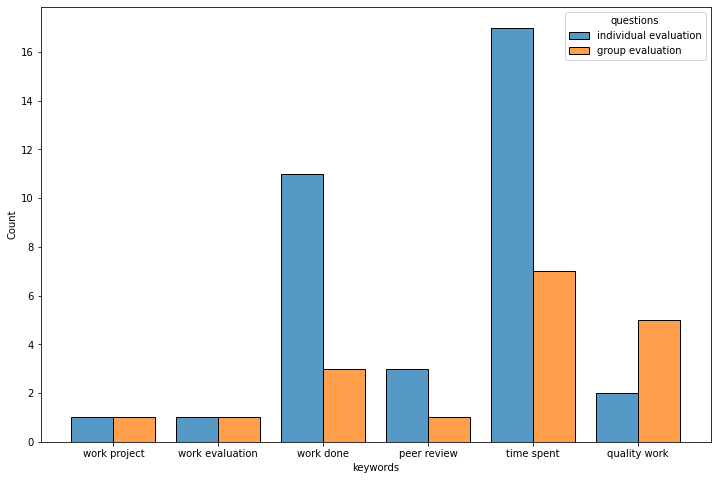

In [24]:
#fd_bigram_52.most_common(20)
#fd_bigram_52[('evaluate', 'collaboration')]
data = common_terms_bigram(fd_bigram_51,fd_bigram_52,['individual evaluation','group evaluation'],
 ['collaboration', 'spent','time', 'project','contribution','time','peer','work','done','evaluation','quality','speak'])                          
#['member','contribution','contributing','completed','collaboration', 'spent','time','peer','work','done','evaluation','quality','speaking','review'])
#data
generate_histo(data,['questions','keywords'],(12 ,8))

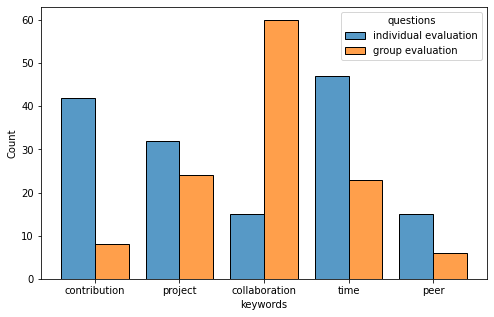

In [ ]:
data= common_terms([[fd_51,'individual evaluation'],[fd_52,'group evaluation']],['collaboration', 'time', 'project','contribution','time','peer'])
#df2 = create_data_frame(data,['questions','keywords'])
#generate_correlation(data,['questions','keywords'])
#generate_histo(data,['questions','keywords'],(8,5))
#generate_correlation(data,['questions','keywords'])


In [30]:
#------topic modeling for question 57 -----------
lda_model,corpus,id2word = run_topic_modeling(df.Q57.str.cat(sep = ' '),'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
18     0.210672 -0.089460       1        1  8.880107
7      0.194417  0.124499       2        1  8.255637
4     -0.248666 -0.008394       3        1  8.101526
13    -0.185808 -0.081660       4        1  7.717252
9     -0.058363 -0.288205       5        1  7.518484
12     0.078379 -0.173985       6        1  6.393221
6     -0.108119 -0.169379       7        1  6.270998
1      0.220869  0.019802       8        1  5.918349
16     0.071980  0.200663       9        1  5.648234
8      0.137440 -0.160279      10        1  5.602603
19    -0.049787 -0.111880      11        1  5.013132
10     0.106864  0.111838      12        1  4.719415
3      0.106538 -0.010257      13        1  4.294820
0     -0.148846  0.177146      14        1  4.041076
15    -0.042515  0.231608      15        1  3.448516
2     -0.096867  0.063990      16        1  2.579582
17    -0.002734 -0.033550      17        1  2.308769
14    -0.139789  0.094113      18        1  2.142427
5     -0.018986  0.056856      19        1  0.788894
11    -0.026678  0.046536      20        1  0.356961, topic_info=              Term       Freq      Total Category  logprob  loglift
65             job   7.000000   7.000000  Default  30.0000  30.0000
6         everyone  11.000000  11.000000  Default  29.0000  29.0000
126         person  12.000000  12.000000  Default  28.0000  28.0000
44   collaboration  22.000000  22.000000  Default  27.0000  27.0000
13        progress  15.000000  15.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
24      discussion   0.007617   8.537480  Topic20  -6.2442  -1.3865
25          moment   0.007617   2.053197  Topic20  -6.2442   0.0386
26           speak   0.007617   2.033869  Topic20  -6.2442   0.0480
27    conversation   0.007617   4.761192  Topic20  -6.2442  -0.8025
29       direction   0.007617   1.350014  Topic20  -6.2442   0.4579

[928 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
219       3  0.569201          able
219       6  0.284601          able
219      11  0.284601          able
426      16  0.864551    accomplish
250      14  0.784128  accomplished
...     ...       ...           ...
58       13  0.094721       working
58       17  0.094721       working
355       2  0.498106       writing
355      15  0.498106       writing
143       4  0.727308           yet

[776 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 8, 5, 14, 10, 13, 7, 2, 17, 9, 20, 11, 4, 1, 16, 3, 18, 15, 6, 12])

# **Concordance**

In [35]:
concordance(df.Q57.str.cat(sep = ' ') ,"different") 
print(" ")
fd_57 = most_common_vocab(df.Q57.str.cat(sep = ' '))
fd_bigram_57 = most_common_bigram(df.Q57.str.cat(sep = ' '))
fd_57.tabulate(20)

Displaying 10 of 10 matches:
ke to see tasks being delegated to different members , as well as each member '
 It would be interesting to see at different points of the collaboration what e
others . The relative amounts that different group members speak in discussions
s of the project , elaborated by a different member each time . I am not sure w
tages perhaps , the integration of different inputs into the collective task Th
tion about logs of what all things different people in the team have contribute
otions that they are feeling . the different segments of collaboration A simila
ollaboration product parts between different members ' contributions Whether ev
oup level . Collaboration based on different technical designs or different cha
 on different technical designs or different characteristics needed in making a
 
        group           see         would          like collaboration          work        member          time        people      everyone   information      progress  

In [29]:
#------topic modeling for question 55 -----------
lda_model,corpus,id2word = run_topic_modeling(df.Q55.str.cat(sep = ' '),'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.162061 -0.169505       1        1  9.841080
12     0.234509 -0.048790       2        1  9.052834
14    -0.108902 -0.189079       3        1  8.872895
0     -0.216460 -0.046014       4        1  7.670880
13     0.061186 -0.128090       5        1  7.378882
17     0.026296 -0.298302       6        1  6.822338
8     -0.014360 -0.180157       7        1  6.500368
9     -0.185864 -0.119120       8        1  6.062303
19     0.203850  0.166625       9        1  5.830221
4      0.149832 -0.064567      10        1  5.349041
15     0.106933  0.012944      11        1  4.581194
18    -0.057881  0.208731      12        1  4.041934
2      0.143254  0.112383      13        1  3.954232
5     -0.196184  0.108326      14        1  3.139963
3      0.035837  0.214307      15        1  2.401823
16    -0.115035  0.150197      16        1  2.326860
7     -0.141231  0.039201      17        1  2.291379
6     -0.067274  0.030615      18        1  1.631941
1      0.000155  0.129182      19        1  1.398042
11    -0.020723  0.071113      20        1  0.851790, topic_info=            Term       Freq      Total Category  logprob  loglift
79           job   8.000000   8.000000  Default  30.0000  30.0000
47     real_time  19.000000  19.000000  Default  29.0000  29.0000
8    information  31.000000  31.000000  Default  28.0000  28.0000
56          work  24.000000  24.000000  Default  27.0000  27.0000
282    would_use  33.000000  33.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
15       similar   0.015655   1.973238  Topic20  -6.5468  -0.0711
16       account   0.015655   1.451359  Topic20  -6.5468   0.2361
18         aware   0.015655   1.454815  Topic20  -6.5468   0.2337
19       clearly   0.015655   1.454815  Topic20  -6.5468   0.2337
20       connect   0.015655   1.454815  Topic20  -6.5468   0.2337

[939 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
32        1  0.189009       able
32        3  0.189009       able
32        4  0.378018       able
32        7  0.189009       able
32        8  0.189009       able
...     ...       ...        ...
282      10  0.090612  would_use
282      11  0.030204  would_use
282      12  0.030204  would_use
282      14  0.030204  would_use
282      17  0.030204  would_use

[847 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 13, 15, 1, 14, 18, 9, 10, 20, 5, 16, 19, 3, 6, 4, 17, 8, 7, 2, 12])

# **Concordance**

In [34]:
concordance(df.Q55.str.cat(sep = ' ') ,"mistake") 
print(" ")
fd_55 = most_common_vocab(df.Q55.str.cat(sep = ' '))
fd_bigram_55 = most_common_bigram(df.Q55.str.cat(sep = ' '))
fd_55.tabulate(20)

no matches
 
        would         group           use collaboration   information          work        member        people           see          help          make         could          time          need          well          know        adjust          team          task      progress 
           88            64            56            51            43            34            31            26            23            19            18            18            17            15            14            14            12            12            12            12 


In [ ]:
#fd_55.most_common(100)

In [28]:
#------topic modeling for question 58 -----------
lda_model,corpus,id2word = run_topic_modeling(df.Q58.str.cat(sep = ' '),'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15    -0.183864 -0.177439       1        1  12.698248
10    -0.270761 -0.024451       2        1  11.891422
19    -0.071540 -0.200501       3        1  10.553579
13    -0.010929 -0.239651       4        1   9.150096
14     0.030806  0.315885       5        1   7.109449
18    -0.180042 -0.015739       6        1   5.886129
9     -0.190174  0.126121       7        1   4.545384
2     -0.146556 -0.074311       8        1   4.497934
8      0.119434 -0.175665       9        1   4.405500
1      0.038161 -0.131225      10        1   4.050244
17     0.243315 -0.096696      11        1   3.948241
7      0.232052  0.077922      12        1   3.495979
16    -0.053106  0.092638      13        1   3.118136
11     0.039360  0.162501      14        1   2.996918
0     -0.076211  0.197789      15        1   2.857306
4      0.167690  0.138721      16        1   2.516831
5     -0.001185 -0.006382      17        1   2.218527
6      0.097677  0.004392      18        1   1.683333
12     0.159950 -0.008511      19        1   1.597240
3      0.055924  0.034602      20        1   0.779503, topic_info=              Term       Freq      Total Category  logprob  loglift
21   collaboration  49.000000  49.000000  Default  30.0000  30.0000
63           group  29.000000  29.000000  Default  29.0000  29.0000
43             see  35.000000  35.000000  Default  28.0000  28.0000
4             time  13.000000  13.000000  Default  27.0000  27.0000
157           well  17.000000  17.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
21   collaboration   0.015544  49.309195  Topic20  -6.2383  -3.2079
22    collaborator   0.015544   1.895498  Topic20  -6.2383   0.0507
23            fact   0.015544   1.342417  Topic20  -6.2383   0.3957
24          fellow   0.015544   1.342417  Topic20  -6.2383   0.3957
25     necessarily   0.015544   2.179413  Topic20  -6.2383  -0.0888

[856 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
369      18  0.880265  ability
5         2  0.231225     able
5         4  0.462449     able
5        10  0.231225     able
5        16  0.231225     able
...     ...       ...      ...
136       8  0.528503    write
136      17  0.528503    write
346      15  0.800330    wrong
133       1  0.671032      yet
405      12  0.777479    yield

[643 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 11, 20, 14, 15, 19, 10, 3, 9, 2, 18, 8, 17, 12, 1, 5, 6, 7, 13, 4])

# **Concordance**

In [31]:
concordance(df.Q58.str.cat(sep = ' ') ,"peer") 
print(" ")
fd_58 = most_common_vocab(df.Q58.str.cat(sep = ' '))
fd_bigram_58 = most_common_bigram(df.Q58.str.cat(sep = ' '))
fd_58.tabulate(20)

Displaying 8 of 8 matches:
collaboration Time spent , anonymous peer ratings on collaboration Maybe some 
 would like to see feedback report , peer evaluations and project evaluation a
of a specific idea or path to take . peer reviews Each person providing an ano
 everyone said . I would like to see peer evaluations to see how well the grou
t of the work Similar to real-time , peer review but maybe with the addition o
 how they thought the session went . peer reviews Whether every member of the 
 develop , etc . I would like to see peer reviews as to what each peer thought
 to see peer reviews as to what each peer thought of the others . maybe sugges
 
collaboration         would         group           see          like        member          work          well       project   information          time        people          felt    individual          much       nothing      everyone        result        person         think 
           60            56            53            46   

In [27]:
#------topic modeling for question 59 -----------
lda_model,corpus,id2word = run_topic_modeling(df.Q59.str.cat(sep = ' '),'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.103647  0.141903       1        1  13.719479
7     -0.126874 -0.097007       2        1   8.828767
18    -0.038035  0.227665       3        1   8.579373
16    -0.225301 -0.004389       4        1   7.170312
15    -0.171106  0.157808       5        1   7.001600
10     0.150445  0.216052       6        1   6.935869
2      0.310623 -0.028602       7        1   6.443851
13    -0.214778  0.067524       8        1   6.117106
0      0.014998  0.160493       9        1   5.051801
3     -0.189693 -0.161120      10        1   3.931341
1     -0.056015 -0.233466      11        1   3.487882
12     0.064345  0.044002      12        1   3.094657
6     -0.056584  0.026822      13        1   3.006815
8      0.099285 -0.202463      14        1   2.779378
19     0.142620 -0.105744      15        1   2.732419
14     0.168080  0.022712      16        1   2.610985
9      0.136975  0.104094      17        1   2.593446
11     0.018872 -0.172008      18        1   2.407699
4      0.008331 -0.057059      19        1   1.891670
5      0.067459 -0.107215      20        1   1.615549, topic_info=              Term       Freq      Total Category  logprob  loglift
15         improve  20.000000  20.000000  Default  30.0000  30.0000
255      would_use  27.000000  27.000000  Default  29.0000  29.0000
65   collaboration  35.000000  35.000000  Default  28.0000  28.0000
33            work  27.000000  27.000000  Default  27.0000  27.0000
14           group  34.000000  34.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
8           course   0.023441   1.442763  Topic20  -6.7523   0.0056
9        efficient   0.023441   3.848975  Topic20  -6.7523  -0.9756
10             far   0.023441   1.442690  Topic20  -6.7523   0.0057
11        feedback   0.023441   5.198447  Topic20  -6.7523  -1.2762
13            gain   0.023441   1.525797  Topic20  -6.7523  -0.0503

[915 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
345       2  0.450989          able
345       8  0.450989          able
386       8  0.707459        access
166       4  0.692775    accomplish
454       5  0.361259  accomplished
...     ...       ...           ...
255      16  0.036572     would_use
255      17  0.036572     would_use
165       1  0.341652         wrong
165       2  0.341652         wrong
165      14  0.341652         wrong

[858 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 8, 19, 17, 16, 11, 3, 14, 1, 4, 2, 13, 7, 9, 20, 15, 10, 12, 5, 6])

# **Concordance**

In [32]:
concordance(df.Q59.str.cat(sep = ' ') ,"peer") 
print(" ")
fd_59 = most_common_vocab(df.Q59.str.cat(sep = ' '))
fd_bigram_59 = most_common_bigram(df.Q59.str.cat(sep = ' '))
fd_58.tabulate(20)

Displaying 3 of 3 matches:
ether I am a good collaborator , use peer evaluations to check where exactly I
g hard on our next session . again , peer reviews allow people to see what the
ished I would use it to see how each peer thought of themselves as well as how
 
collaboration         would         group           see          like        member          work          well       project   information          time        people          felt    individual          much       nothing      everyone        result        person         think 
           60            56            53            46            45            43            31            22            20            19            17            17            16            14            14            14            13            13            13            12 


In [ ]:
fd_59['dynamic']

6

# **Keyword correlaton accross questions**

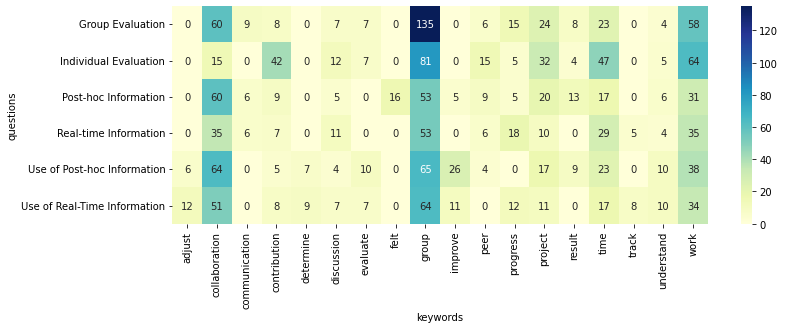

In [36]:
data = most_freq_words_across_questions([[fd_51,'Individual Evaluation'],[fd_52,'Group Evaluation'],[fd_57,'Real-time Information'],
                                         [fd_55,'Use of Real-Time Information'],[fd_58,'Post-hoc Information'],[fd_59,'Use of Post-hoc Information']],
                                        ['project','collaboration','work','contribution','group','time','peer','discussion',
                                         'progress','track','adjust','evaluate','determine','felt','improve','understand','result','communication'])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,4))
#generate_histo(data,['questions','keywords'],(20,8))

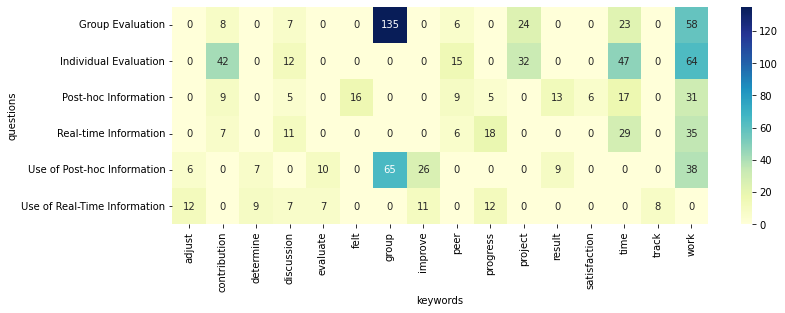

In [41]:
data = most_freq_words_across_questionsV2([[fd_51,'Individual Evaluation'],[fd_52,'Group Evaluation'],[fd_57,'Real-time Information'],
                                         [fd_55,'Use of Real-Time Information'],[fd_58,'Post-hoc Information'],[fd_59,'Use of Post-hoc Information']],
                                        [['contribution','discussion','peer','project','time','work'],['contribution','discussion','group','peer','project','time','work'],
                                         ['contribution','discussion','peer','progress','time','work'], ['adjust','evaluate','improve','determine','progress','discussion','track'],
                                         ['contribution','discussion','felt','peer','progress','time','work','result','satisfaction'], ['adjust','evaluate','improve','determine','result','group','work']])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,4))

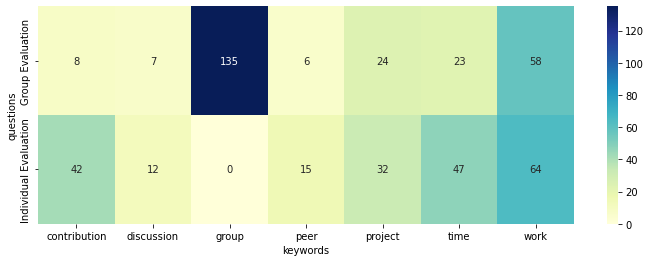

In [42]:
data = most_freq_words_across_questionsV2([[fd_51,'Individual Evaluation'],[fd_52,'Group Evaluation']],
                                        [['contribution','discussion','peer','project','time','work'],
                                         ['contribution','discussion','group','peer','project','time','work']])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,4))

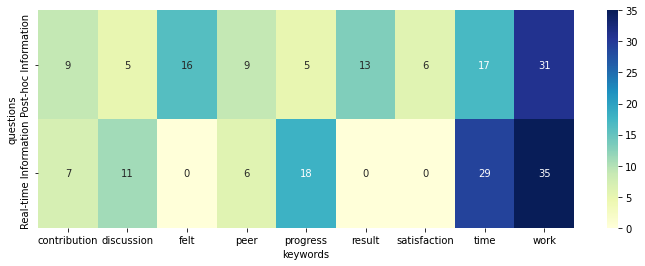

In [43]:
data = most_freq_words_across_questionsV2([[fd_57,'Real-time Information'],[fd_58,'Post-hoc Information']],
                                        [['contribution','discussion','peer','progress','time','work'], 
                                         ['contribution','discussion','felt','peer','progress','time','work','result','satisfaction']])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,4))

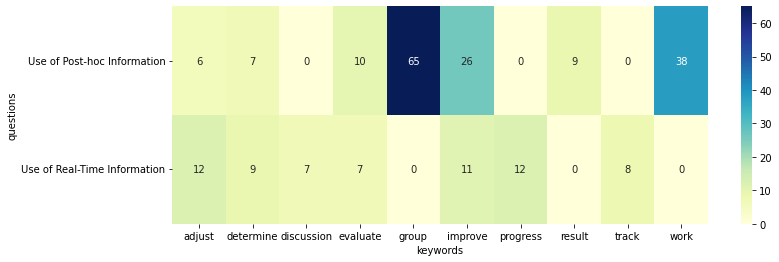

In [44]:
data = most_freq_words_across_questionsV2([
                                         [fd_55,'Use of Real-Time Information'],[fd_59,'Use of Post-hoc Information']],
                                        [['adjust','evaluate','improve','determine','progress','discussion','track'],
                                         ['adjust','evaluate','improve','determine','result','group','work']])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,4))

In [ ]:
concordance(df.Q51.str.cat(sep = ' ') ,"collaboration")

# **Common Keywords across questions**

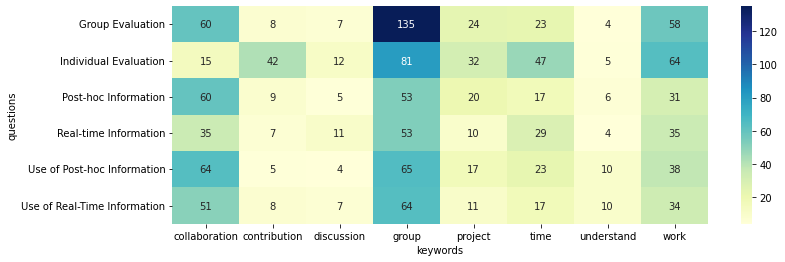

In [ ]:
data = common_terms([[fd_51,'Individual Evaluation'],[fd_52,'Group Evaluation'],[fd_57,'Real-time Information'],
                                         [fd_55,'Use of Real-Time Information'],[fd_58,'Post-hoc Information'],[fd_59,'Use of Post-hoc Information']],
                                        ['project','collaboration','work','contribution','group','time','peer','discussion',
                                         'progress','track','adjust','evaluate','determine','felt','improve','understand','result','communication'])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,4))
#generate_histo(data,['questions','keywords'],(16,8))

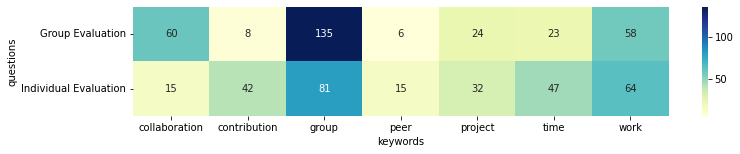

In [ ]:
data = common_terms([[fd_51,'Individual Evaluation'],[fd_52,'Group Evaluation']],
                    ['group','work','collaboration', 'time', 'project','contribution','time','peer','Discussion'])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,2))
#generate_histo(data,['questions','keywords'],(12,5))

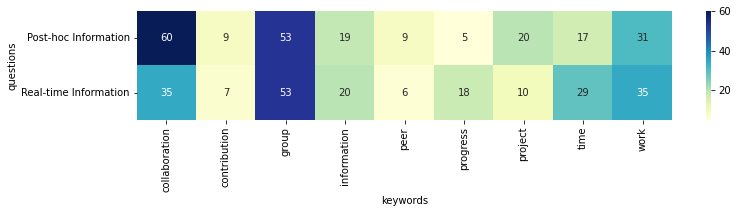

In [ ]:
data = common_terms([[fd_57,'Real-time Information'],[fd_58,'Post-hoc Information']],
                                        ['group','work','collaboration', 'time', 'project','contribution','time','peer','Discussion',
                                         'information','progress','felt','satisfaction'])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,2))
#generate_histo(data,['questions','keywords'],(12,5))

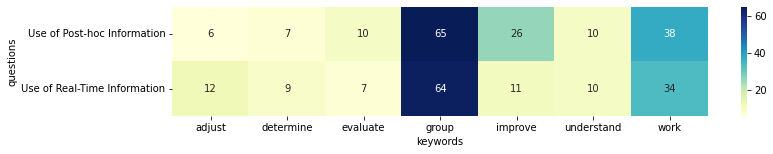

In [ ]:
data = common_terms([[fd_55,'Use of Real-Time Information'],[fd_59,'Use of Post-hoc Information']],
                                        ['group','work','progress','track','adjust','evaluate','determine','improve','understand','result'])
df2 = create_data_frame(data,['questions','keywords'])
generate_correlation(data,['questions','keywords'],(12,2))
#generate_histo(data,['questions','keywords'],(12,5))

# **Sentiment Analysis Correlation**

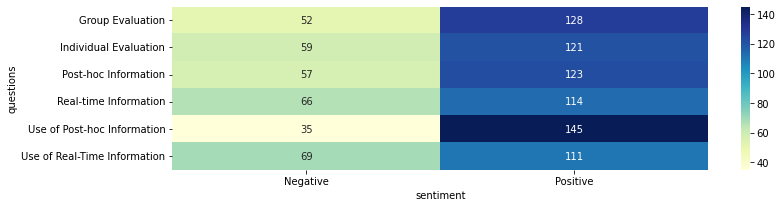

In [ ]:
#generate_histo(sentiment_data,['questions','sentiment'],(8,5))
generate_correlation(sentiment_data,['questions','sentiment'],(12,3))

In [ ]:
# ----- TOPIC MODELING OF ALL RESPONSES----

In [ ]:
#------topic modeling for question 51,52,57,55,58,59 -----------
all_responses = df.Q51.str.cat(sep = ' ')+ df.Q52.str.cat(sep = ' ')+df.Q57.str.cat(sep = ' ')+df.Q55.str.cat(sep = ' ')+df.Q58.str.cat(sep = ' ')+df.Q59.str.cat(sep = ' ')
lda_model,corpus,id2word = run_topic_modeling(all_responses,'text')
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word,mds='mmds')#,mds='mmds'
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
15    -0.046372  0.075025       1        1  9.185121
12    -0.240373 -0.112431       2        1  7.510986
7     -0.063298  0.201855       3        1  7.441081
1     -0.123954  0.043865       4        1  7.067756
10    -0.137298  0.174908       5        1  6.992623
3      0.041581  0.273184       6        1  6.427616
8      0.307146 -0.173120       7        1  6.416441
0     -0.220862  0.010936       8        1  6.186659
2      0.124971  0.197824       9        1  4.987706
5     -0.055765 -0.085474      10        1  4.882588
9     -0.146614 -0.083878      11        1  4.357796
4      0.153309 -0.166175      12        1  4.121751
11    -0.211771  0.113827      13        1  4.091931
17     0.094397 -0.006051      14        1  3.856945
13     0.216241 -0.015517      15        1  3.729758
18     0.094265  0.093768      16        1  3.479177
6      0.249787  0.118951      17        1  3.115440
16     0.047520 -0.161819      18        1  2.427567
19    -0.102373 -0.241547      19        1  2.038657
14     0.019461 -0.258131      20        1  1.682400, topic_info=              Term        Freq       Total Category  logprob  loglift
20           group  268.000000  268.000000  Default  30.0000  30.0000
75          finish   31.000000   31.000000  Default  29.0000  29.0000
77     participate   38.000000   38.000000  Default  28.0000  28.0000
27            work  190.000000  190.000000  Default  27.0000  27.0000
69   collaboration  197.000000  197.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
122           find    0.762175   10.987421  Topic20  -5.1161   1.4166
45            talk    0.761310   12.760678  Topic20  -5.1172   1.2659
3         actually    0.755860   14.025784  Topic20  -5.1244   1.1642
15             way    0.755860   30.113030  Topic20  -5.1244   0.4001
27            work    0.755860  190.997170  Topic20  -5.1244  -1.4472

[1281 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
495       3  0.344219  ability
495      14  0.172109  ability
495      16  0.344219  ability
148       1  0.035526     able
148       2  0.177632     able
...     ...       ...      ...
922       1  0.250146  writing
922      15  0.250146  writing
922      19  0.500292  writing
838       6  0.873253      yet
1234     14  0.603476    yield

[2460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[16, 13, 8, 2, 11, 4, 9, 1, 3, 6, 10, 5, 12, 18, 14, 19, 7, 17, 20, 15])

In [ ]:
sia = SentimentIntensityAnalyzer()
positive_review_ids = nltk.corpus.movie_reviews.fileids(categories=["pos"])
negative_review_ids = nltk.corpus.movie_reviews.fileids(categories=["neg"])
all_review_ids = positive_review_ids + negative_review_ids

In [ ]:
def is_positive(review_id: str) -> bool:
    """True if the average of all sentence compound scores is positive."""
    text = nltk.corpus.movie_reviews.raw(review_id)
    #print(text)
    scores = [
        sia.polarity_scores(sentence)["compound"]
        for sentence in nltk.sent_tokenize(text)
    ]
    return mean(scores) > 0


In [ ]:
correct = 0
for review_id in all_review_ids:
     if is_positive(review_id):
        if review_id in positive_review_ids:
             correct += 1
     else:
         if review_id in negative_review_ids:
             correct += 1

print(F"{correct / len(all_review_ids):.2%} correct")

64.05% correct


In [ ]:
unwanted = nltk.corpus.stopwords.words("english")

unwanted.extend([w.lower() for w in nltk.corpus.names.words()])


def skip_unwanted(pos_tuple):

    word, tag = pos_tuple

    if not word.isalpha() or word in unwanted:

        return False

    if tag.startswith("NN"):

        return False

    return True


positive_words = [word for word, tag in filter(

    skip_unwanted,

    nltk.pos_tag(nltk.corpus.movie_reviews.words(categories=["pos"]))

)]

negative_words = [word for word, tag in filter(

    skip_unwanted,

    nltk.pos_tag(nltk.corpus.movie_reviews.words(categories=["neg"]))

)]


In [ ]:
positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)

common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]

top_100_positive = [[word,count] for word, count in positive_fd.most_common(100)]
top_100_negative = {word for word, count in negative_fd.most_common(100)}


In [ ]:
print(positive_fd)

<FreqDist with 5938 samples and 9103 outcomes>


In [ ]:
# USING MOVIE REVIEW SAMPLES TO AS TRAINIG DATA

In [ ]:
def extract_features(text):
    features = dict()
    wordcount = 0
    compound_scores = list()
    positive_scores = list()

    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            if word.lower() in positive_fd:
                wordcount += 1
        compound_scores.append(sia.polarity_scores(sentence)["compound"])
        positive_scores.append(sia.polarity_scores(sentence)["pos"])

    # Adding 1 to the final compound score to always have positive numbers
    # since some classifiers  don't work with negative numbers.
    features["mean_compound"] = mean(compound_scores) + 1
    features["mean_positive"] = mean(positive_scores)
    features["wordcount"] = wordcount

    return features


In [ ]:
positives = 0
negatives = 0
for resp in df.Q51:
  if resp is not nan:
    features = extract_features(resp)
    if features["mean_positive"] > 0:
      positives+=1
    else:
       negatives+=1 
    #print(features)
print("Sentiments --- Positives: ", positives, " Negatives: ",negatives)    


Sentiments --- Positives:  113  Negatives:  91


In [ ]:
all_text = df.Q51.str.cat(sep = ' ') 
text = nltk.Text(nltk.word_tokenize(all_text))
text.concordance("peer", lines=5)

Displaying 5 of 12 matches:
 been present at the team meetings . peer reviews Are they actually participat
tributed to each part of a project . Peer reviews as well . How much time they
esent on the parts they made maybe ? Peer evals potentially Time spent contrib
ossbile but is not always accurate . Peer reviews ( with the understanding tha
esult of their part of work leads to Peer reviews of performance would be usef


In [ ]:
concordance_list = text.concordance_list("group", lines=5)
for entry in concordance_list:
    print(entry.line)

In [ ]:
token = nltk.word_tokenize(all_text_58)
stopwords = nltk.corpus.stopwords.words("english")
words_58 = [w for w in token if w.lower() not in stopwords and w.isalpha()]
text_1 = nltk.Text(words_58)
fd = text_1.vocab()
fd.tabulate(20)

collaboration         would         group           see          like          work       members          well       project   information        people          felt        member          much       Nothing      everyone        person         think          time       quality 
           58            56            51            46            45            29            28            22            19            18            16            16            15            14            14            13            13            12            11            11 


In [ ]:
finder = nltk.collocations.BigramCollocationFinder.from_words(words_58)
finder.ngram_fd.most_common(10)

In [ ]:
nltk.pos_tag(['person'],tagset='universal')

In [ ]:
w = nlp('person')

for token in w:
  print(token.lemma_)